In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import yfinance as yf
import arch

# Load Data using Yahoo Finance

In [5]:
# load data
# Download data from Yahoo Finance
import os
import pandas as pd
import yfinance as yf
import arch

tickers = ['SPY', 'QQQ']

holder = {}
for ticker in tickers:

    file_name = f'{ticker}.csv'
    if not os.path.exists(file_name):
        df = yf.Ticker(ticker).history(start='2018-01-01', end='2023-12-31')
        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True)
    df.index = df.index.tz_convert('US/Eastern')

    holder[ticker] = df

spy = holder['SPY']
qqq = holder['QQQ']

# Calculate daily returns
spy['daily_return'] = spy['Close'].pct_change()
qqq['daily_return'] = qqq['Close'].pct_change()

# Last day's return
print("SPY", spy['daily_return'].iloc[-1])
print("QQQ", qqq['daily_return'].iloc[-1])

# Find Historical VaR
spy_var = spy['daily_return'].dropna().quantile(0.05)
qqq_var = qqq['daily_return'].dropna().quantile(0.05)
print("SPY VaR", spy_var, "QQQ VaR", qqq_var)

spy_vol = spy['daily_return'].dropna().std()
qqq_vol = qqq['daily_return'].dropna().std()
print("SPY Vol", spy_vol, "QQQ Vol", qqq_vol)


SPY -0.002894977560712997
QQQ -0.0043277403326080766
SPY VaR -0.019626306998327632 QQQ VaR -0.025680016426260204
SPY Vol 0.01284364065355119 QQQ Vol 0.015750111044947383


# Q1 Implement the GARCH(1,1)-normal model to forecast future returns.

In [12]:
def estimate_garch_1_1(data):
    garch = arch.arch_model(data['daily_return'].dropna()*100, vol='Garch', p=1, q=1)
    garch_fitted = garch.fit(disp='off')
    return garch_fitted

# GARCH(1,1) on SPY
spy_garch = estimate_garch_1_1(spy)
print(spy_garch.summary())

# GARCH(1,1) on QQQ
qqq_garch = estimate_garch_1_1(qqq)
print(qqq_garch.summary())

# estimate future return based on GARCH(1,1)
spy_forecast = spy_garch.forecast(horizon=1)
qqq_forecast = qqq_garch.forecast(horizon=1)
# assume  a random shock 
shock = np.random.normal(0, 1)
print("SPY forecast return", spy_forecast.mean.iloc[-1]*shock)
print("QQQ forecast return", qqq_forecast.mean.iloc[-1]*shock)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:           daily_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2137.89
Distribution:                  Normal   AIC:                           4283.77
Method:            Maximum Likelihood   BIC:                           4305.05
                                        No. Observations:                 1508
Date:                Sun, Apr 21 2024   Df Residuals:                     1507
Time:                        15:42:41   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1040  2.164e-02      4.804  1.554e-06 [6.155e-0

# Q2 Monte Carlo Simulation (MCS) approach


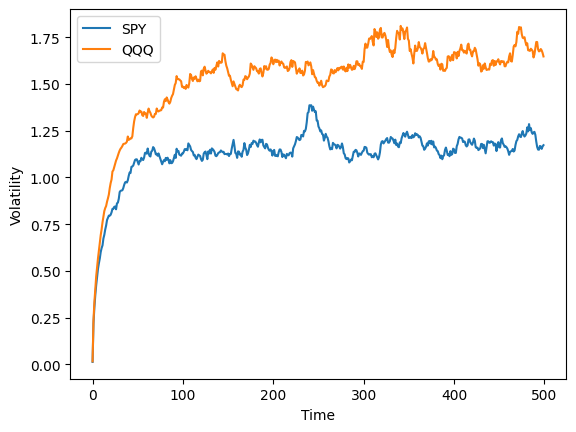

In [63]:
# Implement a function that generates random numbers from a standard normal distribution.
def generate_standard_normal_numbers(size=None):
    return np.random.normal(0, 1, size)
# Update the variances using the GARCH(1,1) equation and compute future returns based on the
#updated variances and random shocks.
def forecast_garch_1_1(garch, shocks):
    forecast = garch.forecast(horizon=1)
    return forecast.mean.iloc[-1] * shocks

# Repeat this process for a specified number of simulation periods to obtain the term structure of risk.
N = 100 # number of simulation periods
T = 500 # forecast horizon
returns = []

def simulate_garch(omega, alpha, beta, last_day_return, last_day_std, N, T, df=None):
    if df is None:
        # return error if df is not provided
        raise ValueError("df is required")
    simulation_return_holder = []
    simulation_volatility_holder = []
    for i in range(N):
        volatility_holder = []
        return_holder = []
        for t in range(T):
            if t ==0:
                # first day
                return_holder.append(last_day_return)
                volatility_holder.append(last_day_std)
            else:
                shock = generate_standard_normal_numbers()
                conditional_volatility = np.sqrt(omega + alpha * (return_holder[-1]**2) + beta * (volatility_holder[-1]**2))
                simulated_return = conditional_volatility * shock
                return_holder.append(simulated_return)
                volatility_holder.append(conditional_volatility)
        simulation_return_holder.append(return_holder)
        simulation_volatility_holder.append(volatility_holder)
    return simulation_return_holder, simulation_volatility_holder

########
spy_garch = {'omega': 0.0476, 'alpha': 0.2037, 'beta': 0.7730, 'last_day_return': -0.00289, 'last_day_std': 0.01284}
qqq_garch = {'omega': 0.0544, 'alpha': 0.1599, 'beta': 0.8247, 'last_day_return': -0.00432, 'last_day_std': 0.01575}


# plot the term structure of risk
spy_simulation, spy_vol_simulation = simulate_garch(**spy_garch, N=N, T=T, df=spy)
qqq_simulation, qqq_vol_simulation = simulate_garch(**qqq_garch, N=N, T=T, df=qqq)


plt.plot(np.mean(spy_vol_simulation, axis=0), label='SPY')
plt.plot(np.mean(qqq_vol_simulation, axis=0), label='QQQ')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

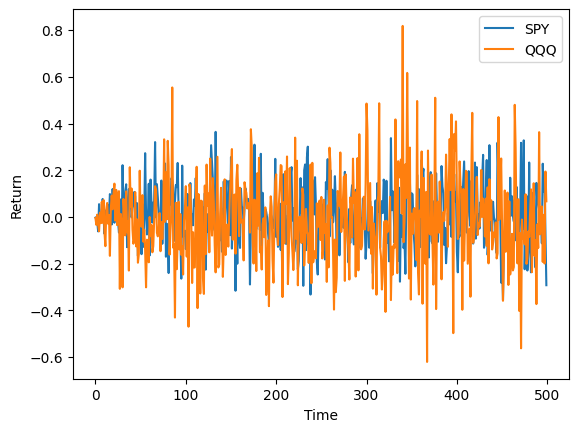

In [64]:
plt.plot(np.mean(spy_simulation, axis=0), label='SPY')
plt.plot(np.mean(qqq_simulation, axis=0), label='QQQ')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.show()

# Q3 VaR and ES calculation for MCS:

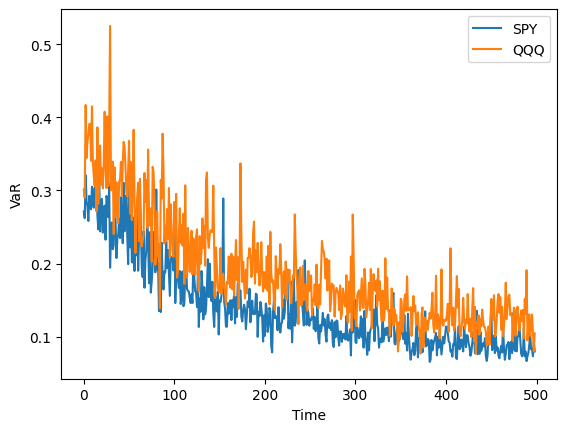

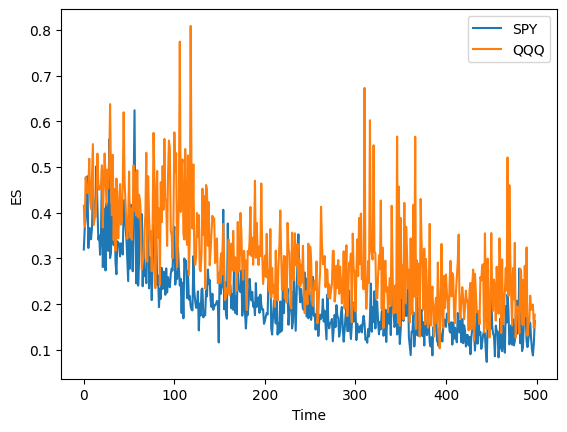

In [72]:
spy_simulation = np.array(spy_simulation)
qqq_simulation = np.array(qqq_simulation)

# Make spy_simulation and qqq_simulation 1d array
spy_simulation_flattened = spy_simulation.flatten()
qqq_simulation_flattened = qqq_simulation.flatten()

confidence_interval = 5

def get_VaR_at_time(t,simulation,alpha=5):
    return np.percentile(simulation[0:,t],alpha)

# Calculate VaR
spy_VaR_holder = []
qqq_VaR_holder = []

for t in range(T):
    if t==0:
        continue
    spy_VaR = -get_VaR_at_time(t,spy_simulation/np.sqrt(t+1),confidence_interval)
    qqq_VaR = -get_VaR_at_time(t,qqq_simulation/np.sqrt(t+1),confidence_interval)
    spy_VaR_holder.append(spy_VaR)
    qqq_VaR_holder.append(qqq_VaR)

plt.plot(spy_VaR_holder, label='SPY')
plt.plot(qqq_VaR_holder, label='QQQ')
plt.xlabel('Time')
plt.ylabel('VaR')
plt.legend()
plt.show()

# Calculate Expected Shortfall
spy_ES_holder = []
qqq_ES_holder = []

for t in range(T):
    if t==0:
        continue
    spy_ES = -np.mean(spy_simulation[0:,t][spy_simulation[0:,t] < get_VaR_at_time(t,spy_simulation,confidence_interval)]/np.sqrt(t+1))
    qqq_ES = -np.mean(qqq_simulation[0:,t][qqq_simulation[0:,t] < get_VaR_at_time(t,qqq_simulation,confidence_interval)]/np.sqrt(t+1))
    spy_ES_holder.append(spy_ES)
    qqq_ES_holder.append(qqq_ES)

plt.plot(spy_ES_holder, label='SPY')
plt.plot(qqq_ES_holder, label='QQQ')
plt.xlabel('Time')
plt.ylabel('ES')
plt.legend()
plt.show()

# Q4 Filtered Historical Simulation (FHS) approach

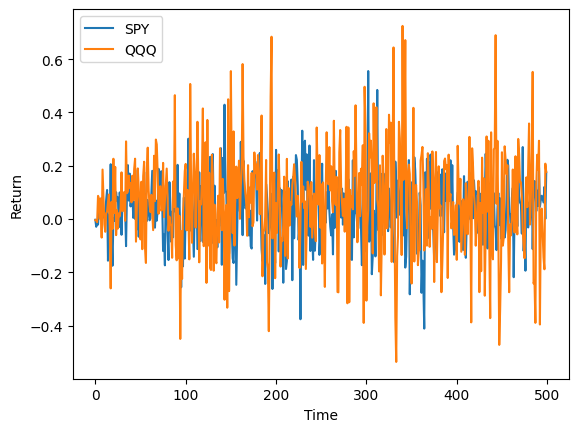

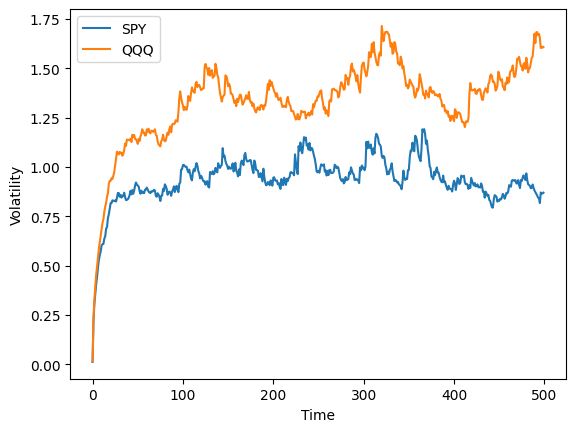

In [75]:
### Since we are seleting historical data as the shock for forecast, the correlation is inherently captured
def fhs(omega, alpha, beta, last_day_return, last_day_std, N, T, df=None):
    if df is None:
        # return error if df is not provided
        raise ValueError("df is required")    
    
    df['z'] = df['daily_return'] / df['daily_return'].std()
    z = list(df['z'].dropna().values)
    simulation_return_holder = []
    simulation_volatility_holder = []
    for i in range(N):
        volatility_holder = []
        return_holder = []
        for t in range(T):
            if t ==0:
                # first day
                return_holder.append(last_day_return)
                volatility_holder.append(last_day_std)
            else:
                #FHS
                shock = np.random.choice(z)
                conditional_volatility = np.sqrt(omega + alpha * (return_holder[-1]**2) + beta * (volatility_holder[-1]**2))
                simulated_return = conditional_volatility * shock
                return_holder.append(simulated_return)
                volatility_holder.append(conditional_volatility)
        simulation_return_holder.append(return_holder)
        simulation_volatility_holder.append(volatility_holder)
    return simulation_return_holder, simulation_volatility_holder

spy_simulation, spy_vol_simulation = fhs(**spy_garch, N=N, T=T, df=spy)
qqq_simulation, qqq_vol_simulation = fhs(**qqq_garch, N=N, T=T, df=qqq)

# Plot the simulation
plt.plot(np.mean(spy_simulation, axis=0), label='SPY')
plt.plot(np.mean(qqq_simulation, axis=0), label='QQQ')

plt.xlabel('Time')
plt.ylabel('Return')

plt.legend()
plt.show()

# Plot the volatility simulation
plt.plot(np.mean(spy_vol_simulation, axis=0), label='SPY')
plt.plot(np.mean(qqq_vol_simulation, axis=0), label='QQQ')

plt.xlabel('Time')
plt.ylabel('Volatility')

plt.legend()
plt.show()

# Q5 VaR and ES calculation for FHS:

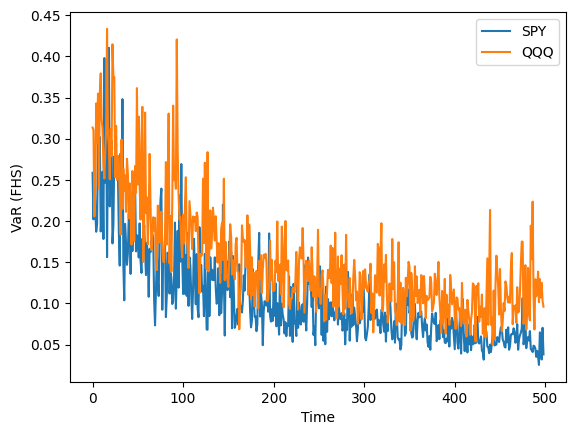

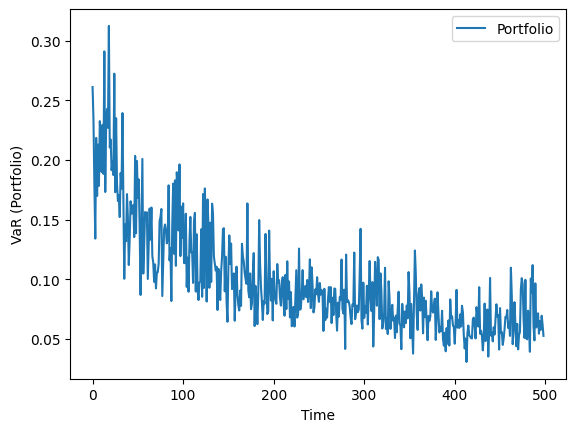

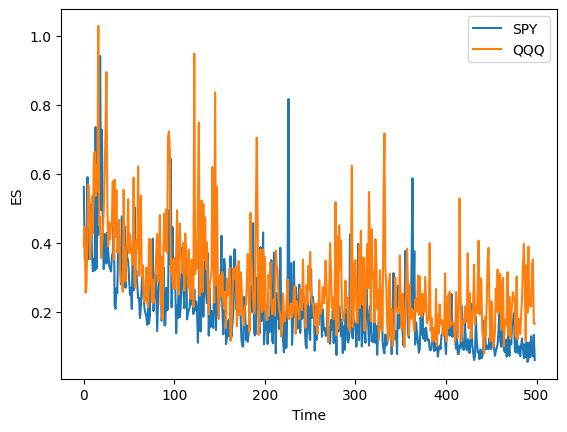

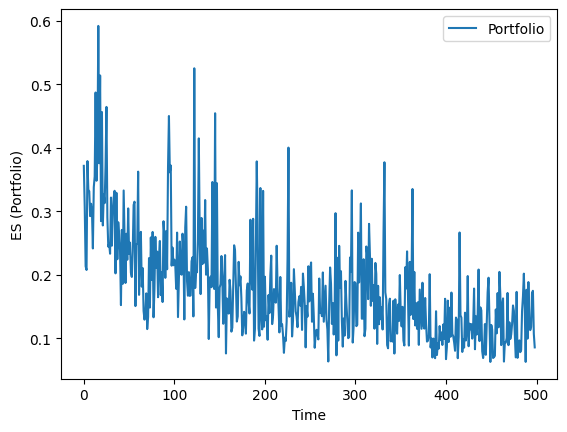

In [81]:
spy_simulation = np.array(spy_simulation)
qqq_simulation = np.array(qqq_simulation)


confidence_interval = 5

spy_VaR_holder = []
qqq_VaR_holder = []

# Calculate VaR
for t in range(T):
    if t==0:
        continue
    spy_VaR = -get_VaR_at_time(t,spy_simulation/np.sqrt(t+1),confidence_interval)
    qqq_VaR = -get_VaR_at_time(t,qqq_simulation/np.sqrt(t+1),confidence_interval)
    spy_VaR_holder.append(spy_VaR)
    qqq_VaR_holder.append(qqq_VaR)

plt.plot(spy_VaR_holder, label='SPY')
plt.plot(qqq_VaR_holder, label='QQQ')
plt.xlabel('Time')
plt.ylabel('VaR (FHS)')
plt.legend()
plt.show()

# VaR for portfolio
portfolio_simulation = (spy_simulation + qqq_simulation) / 2
portfolio_VaR_holder = []
for t in range(T):
    if t == 0:
        continue
    portfolio_VaR = -get_VaR_at_time(t, portfolio_simulation/np.sqrt(t+1), confidence_interval)
    portfolio_VaR_holder.append(portfolio_VaR)

plt.plot(portfolio_VaR_holder, label='Portfolio')
plt.xlabel('Time')
plt.ylabel('VaR (Portfolio)')
plt.legend()
plt.show()

# Calculate Expected Shortfall
spy_ES_holder = []
qqq_ES_holder = []

for t in range(T):
    if t==0:
        continue
    spy_ES = -np.mean(spy_simulation[0:,t][spy_simulation[0:,t] < get_VaR_at_time(t,spy_simulation,confidence_interval)]/np.sqrt(t+1))
    qqq_ES = -np.mean(qqq_simulation[0:,t][qqq_simulation[0:,t] < get_VaR_at_time(t,qqq_simulation,confidence_interval)]/np.sqrt(t+1))
    spy_ES_holder.append(spy_ES)
    qqq_ES_holder.append(qqq_ES)

plt.plot(spy_ES_holder, label='SPY')
plt.plot(qqq_ES_holder, label='QQQ')
plt.xlabel('Time')
plt.ylabel('ES')
plt.legend()
plt.show()

# ES for portfolio
portfolio_ES_holder = []
for t in range(T):
    if t == 0:
        continue
    portfolio_ES = -np.mean(portfolio_simulation[0:,t][portfolio_simulation[0:,t] < get_VaR_at_time(t, portfolio_simulation, confidence_interval)]/np.sqrt(t+1))
    portfolio_ES_holder.append(portfolio_ES)

plt.plot(portfolio_ES_holder, label='Portfolio')
plt.xlabel('Time')
plt.ylabel('ES (Portfolio)')
plt.legend()
plt.show()


# Q6 Comparison and analysis



### On Risk Measure
Both methods give out similar result in terms of VaR and ES, that as the simulation period increases, both VaR and ES decrease gradually, with temporary extreme shocks being seen over the period. 

## For MCS-GARCH model:
### Advantage:
Flexibility to incorporate different distributional assumptions for the innovations (e.g., Student's t-distribution, skewed distributions).
Ability to capture time-varying volatility and volatility clustering through the GARCH model.
Straightforward to extend to other GARCH variants (e.g., GJR-GARCH, EGARCH) or stochastic volatility models.

### Disadvantage:
Relies on the correct specification of the volatility model and distributional assumptions.
Simulation results can be sensitive to the choice of model parameters and the length of the estimation window.
May not accurately capture extreme events or structural breaks in the data.

### Limitation:
Relies on the correct specification of the volatility model and distributional assumptions.
Simulation results can be sensitive to the choice of model parameters and the length of the estimation window.
May not accurately capture extreme events or structural breaks in the data.

## For FHS model:
### Advantage:
It estimates a volatility model (e.g., GARCH) using historical data.
Reconstruct simulated returns by multiplying the simulated standardized returns by the forecasted conditional volatilities from the volatility model --> better represent the real situation that happened in the past
It takes into account of the extreme events happened in thr past -> making it most robust in the modelling capabilities.
### Disadvantage:
When the data in the past is biased/sample size is small, it may not be able to represent the true state when making forecast in the future (e.g., cases where the entire lookback period is of very low volatility, but a sudden change in macro event like the pandemic caused an drastic increase in volatility)
### Limitation:
Sensitive to the choice of volatility model and the length of the estimation window.
May not accurately capture extreme events beyond the historical sample.
Resampling from a limited historical sample may introduce biases or underestimate risk.